# Project Category Identification NLP Project <a id='Data Overview'></a>

## Table of Contents <a id='2.1_Contents'></a>
* [0. Background](#0)
* [1. Data Import - Building Dataset](#1)
* [2. Target Location Selection](#2)
* [3. Data Understanding](#3)
    * [3.1 Missing Values](#3.1)
    * [3.2 Meter Type Observation](#3.2)
    * [3.3 Building Area Observation](#3.3)
    * [3.4 Building Category Observation](#3.4)
    * [3.5 Building Energy Use Intensity](#3.5)
    * [3.6 Other Building Parameters](#3.6)
* [4.0 Save Data](#4.0)

## 0. Background

I built a web scrapping tool that scraps biding and tendering information from public sectors in Ontario. The public sectors includes regions such as York Region, Peel Region, Halton Region, and cities such as City of Mississauga.

The intend of the project is to use DATA to tell a story about the Competitiveness of the public sector. The collected information are used to conduct the following analysis:

* **Public Sector Market Understanding**: an overview of the public sector markets (services, construction, and goods), how the market changes over time.

* **Competitive Information**: an overview of the performance of private companies in different public sectors. What is their wining rate comparing with their competitors. The private companies includes construction companies such as Maple Reinders Constructors Ltd. and Kenaidan Contracting Ltd., consulting companies such WSP Canada Inc., Hatch Ltd., and good supplying companies.

* **Competitiveness by Category** Different private companies in the public sectors have overlapping skill sets in the public sectors, they may also specialize a niche that company leaders and strategist may not be aware off. The tool intends to use DATA to show competitiveness of each companies in different sectors such as consulting in water & wastewater, construction in civil engineering works, etc.

The collected information includes project names and a generic category information. In order to understand "Competitiveness by Category", the original "generic category" needs to further broken down into detailed categories. There are almost 10k project collected, it is not practical to provide a detailed category to each of the project,. Further more, as more projects be collected, manual tagging the category is timing consuming.

Therefore, Natural Language Processing (NLP) is used to do the category task for current projects and any future projects.

## 0.1 Import Libraries

In [22]:
import pandas as pd
import numpy as np
import dataresource as dr

## 0.2 Import Original Dataset

In [23]:
path = "../NaturalLanguageProcessing/DataUpdate.csv"
df = pd.read_csv(path)
df.drop_duplicates(inplace=True)

## 1. Data Wrangling

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7246 entries, 0 to 7245
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          7246 non-null   int64 
 1   client_name         7246 non-null   object
 2   project_name        7246 non-null   object
 3   Category            2591 non-null   object
 4   bid_classification  7246 non-null   object
 5   bid_type            7246 non-null   object
 6   bid_ID              7246 non-null   object
 7   awarded_date        7246 non-null   object
 8   awarded_year        7246 non-null   int64 
 9   company_name        7246 non-null   object
dtypes: int64(2), object(8)
memory usage: 622.7+ KB


In [25]:
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,client_name,project_name,Category,bid_classification,bid_type,bid_ID,awarded_date,awarded_year,company_name
0,Brant County,"1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...",Producer/Supplier,Goods,RFQ,OPS-RFQ-20-07,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
1,Brant County,1 (One) Seven (7) Passenger Mini-Van,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-04,2021-03-26 0:00,2020,Oxford Dodge Chrysler (1992) LTD
2,Brant County,1 (One) Seven (7) Passenger Van / Wagon,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-10,2021-03-26 0:00,2020,East Court Ford Lincoln Oxford Dodge Chr...
3,Brant County,1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-08,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
4,Brant County,1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck,Producer/Supplier,Goods,RFQ,OPS-RFQ-20-09,2021-03-26 0:00,2020,East Court Ford Lincoln Finch Auto Group...


## 1.1 Data Exploration

### 1.1.1 Data Exploration - client_name

In [26]:
client_list = df.client_name.unique().tolist()
len(client_list)

19

In [27]:
client_list

['Brant County',
 'City Of Peterborough',
 'City of Barrie',
 'City of Brantford',
 'City of Guelph',
 'City of Hamilton',
 'City of Kawartha Lakes',
 'City of London',
 'City of Orillia',
 'Dufferin County',
 'Durham Region',
 'Haldimand County',
 'Halton Region',
 'Niagara Region',
 'Peel Region',
 'Peterborough County',
 'Simcoe County',
 'Waterloo Region',
 'York Region']

<AxesSubplot:>

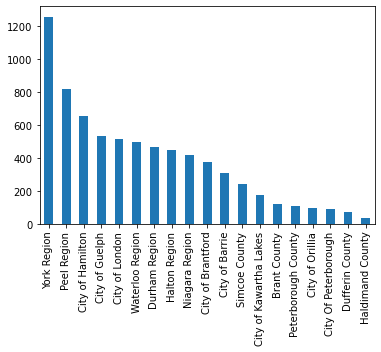

In [28]:
df.client_name.value_counts().plot.bar()

There are 19 clients included in the dataset. The client name will not be used as an input for NLP because the client name does not have any affect on the project name and project category.York Region has a good record of their public projects online.

### 1.1.2 Data Exploration - bid_type

There are a couple of bid types in the business of the public sector: Request for Tender(RFT), Request for Proposal(RFP), Request for Quotation(RFQ), Request for Information (RFI), and Request for Pre-Qualification(RFPQ).

In [29]:
df.bid_type.describe()

count     7246
unique      58
top        RFT
freq      1207
Name: bid_type, dtype: object

In [30]:
df.bid_type.unique().tolist()

['RFQ',
 'Tender',
 'RFP',
 'ITT',
 'RFSQ',
 'RFQ – High Score',
 'RFQ – Low Bid',
 'RFP – Consecutive Negotiation',
 'Non-Standard Procurement',
 'RFSQ – Prequalification',
 'Notice',
 'RFT',
 'RFQ (<)',
 'RFD (Disposal)',
 'RFPQ',
 'RFRC',
 'RFP - Revenue Generating',
 'RFP - Goods and Services',
 'RFP - Prime Consultant',
 'RFT - Construction - Stipulated Price - CCDC',
 'RFT - Public Works',
 'RFT - Construction - Unit Price',
 'RFT - Goods and Services',
 'RFT - Revenue Generating',
 'RFT - Vehicle',
 'Request For Quotation',
 'Request For Proposal',
 'Request For Supplier Qualification',
 'Request for Tender',
 'Request for Proposal',
 'Request for Qualifications',
 'Request for Quotation (Formal)',
 'Request for Information',
 'Informal Request for Quotation',
 'RFEOI',
 'Request for Supplier Pre-qualification',
 'Request For Quotations',
 'N',
 'NRFP',
 'Request For Tender',
 'Request For PreQualification',
 'Request for Proposal(N)',
 'DN',
 'VOR',
 'RFO',
 'Request for Offer'

In [31]:
df.bid_type.value_counts(dropna = False)

RFT                                             1207
Tender                                          1200
RFP                                             1188
Request for Tender                               671
RFQ                                              332
Request For Proposal                             295
Pre-Qualification                                223
Request For Quotation                            195
Request For Tender                               176
Request for Proposal                             176
RFT - Goods and Services                         157
RFT - Public Works                               152
RFPQ                                             123
RFP - Goods and Services                         104
RFQ – Low Bid                                    101
ITT                                               97
RFT - Construction - Stipulated Price - CCDC      91
Request for Quotation (Formal)                    85
RFP – Consecutive Negotiation                 

As we can see the bid types are not unified across different regions/cities, a hashmap is developed to revise values.

In [32]:
df.bid_type = df.bid_type.apply(lambda x : dr.bid_type_Standard.get(x))

In [33]:
df

,client_name,project_name,Category,bid_classification,bid_type,bid_ID,awarded_date,awarded_year,company_name
0,Brant County,"1 (One) 1 Ton Heavy Duty 4Wd, Cab And Chassis ...",Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-07,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
1,Brant County,1 (One) Seven (7) Passenger Mini-Van,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-04,2021-03-26 0:00,2020,Oxford Dodge Chrysler (1992) LTD
2,Brant County,1 (One) Seven (7) Passenger Van / Wagon,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-10,2021-03-26 0:00,2020,East Court Ford Lincoln Oxford Dodge Chr...
3,Brant County,1 (One) ½ Ton 8 Cyl Standard Cab 2Wd Pickup Truck,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-08,2021-03-26 0:00,2020,Finch Auto Group GORD ANDERSON AUTOMOTIV...
4,Brant County,1 (One) ¾ Ton 4Wd Standard Cab Pickup Truck,Producer/Supplier,Goods,Request for Quotation(RFQ),OPS-RFQ-20-09,2021-03-26 0:00,2020,East Court Ford Lincoln Finch Auto Group...
...,...,...,...,...,...,...,...,...,...
7241,York Region,York Telecom Network Construction And Maintena...,Construction - Fibre Optic Cable,Goods,Request for Tender(RFT),T-16-118,08-May,2017,Aecon Utilities Black & McDonald Limited...
7242,York Region,York-Durham Line Concrete Box Culvert Replacem...,NaN,Construction,Request for Tender(RFT),16-122,19-Aug,2016,Primrose Contracting (Ont.) Inc. Everstr...
7243,York Region,York-Peel 900Mm Twin Forcemains Combined Air R...,Construction - Water Wastewater Linear,Construction,Request for Tender(RFT),T-19-129,08-Jul,2020,H2Ontario Inc. Jeviso Construction Corpo...
7244,York Region,Yrt/Viva 2021-2025 Strategic Plan And 2017-202...,NaN,Services,Request for Proposal(RFP),P-15-189,24-May,2016,AECOM Canada Ltd. Dillon Consulting Limi...


### 1.1.3 Data Exploration - bid_classification

In [34]:
df.bid_classification.unique()

array(['Goods', 'Construction', 'Services'], dtype=object)

In [35]:
df.bid_classification.value_counts(dropna = False)

Services        3381
Construction    2672
Goods           1193
Name: bid_classification, dtype: int64

There are three type of bid classification: "Services", "Construction", and "Goods".

### 1.1.4 Data Exploration - bid_ID

In [36]:
df.bid_ID.value_counts().sort_values(ascending=False)

C12-06-18    39
17-151        3
17-126        3
19-181        2
17-142        2
             ..
P-15-189      1
T-19-80       1
T-17-02       1
T-16-132      1
P-16-161      1
Name: bid_ID, Length: 7138, dtype: int64

In [37]:
df.bid_ID.unique().size

7138

Note that there are bid that have duplicates IDs.

### 1.1.5 Data Exploration - Category
This is the target, "Category" had been manually added to the dataset for the model analysis.

In [38]:
df.Category.value_counts().sort_values(ascending=False)

Producer/Supplier                            862
Consulting - Water Wastewater Vertical       297
Construction - Water Wastewater Linear       209
Construction - Road                          207
Construction - Water Wastewater Vertical     203
Consulting - Transportation Road/Trainsit    201
Consulting - Geotechnical/Environmental      147
Consulting - Water Wastewater Linear          97
Construction - Facility                       88
Consulting - Facility                         85
Consulting - Others                           65
Construction - Landscaping                    63
Consulting - Transportation Bridge            30
Consulting - Software Services                17
Construction - Fibre Optic Cable              13
Consulting - Landscaping                       6
Consulting- Geotechnical/Environmental         1
Name: Category, dtype: int64

In [39]:
df.Category = df.Category.replace({'Consulting- Geotechnical/Environmental' : "Consulting - Geotechnical/Environmental"})
df.Category.value_counts().sort_values(ascending=False)

Producer/Supplier                            862
Consulting - Water Wastewater Vertical       297
Construction - Water Wastewater Linear       209
Construction - Road                          207
Construction - Water Wastewater Vertical     203
Consulting - Transportation Road/Trainsit    201
Consulting - Geotechnical/Environmental      148
Consulting - Water Wastewater Linear          97
Construction - Facility                       88
Consulting - Facility                         85
Consulting - Others                           65
Construction - Landscaping                    63
Consulting - Transportation Bridge            30
Consulting - Software Services                17
Construction - Fibre Optic Cable              13
Consulting - Landscaping                       6
Name: Category, dtype: int64

We only want to include the rows that contains "Category" in our dataset.

### 1.1.5 Remove Columns

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7246 entries, 0 to 7245
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   client_name         7246 non-null   object
 1   project_name        7246 non-null   object
 2   Category            2591 non-null   object
 3   bid_classification  7246 non-null   object
 4   bid_type            7246 non-null   object
 5   bid_ID              7246 non-null   object
 6   awarded_date        7246 non-null   object
 7   awarded_year        7246 non-null   int64 
 8   company_name        7246 non-null   object
dtypes: int64(1), object(8)
memory usage: 566.1+ KB


In [45]:
# columns to be removed, as they are not contribute to the category results
columns = ['client_name', 'bid_ID', 'awarded_date', 'awarded_year', 'bid_classification']


KeyError: 'Category'

In [47]:
df = df['Category'] != np.nan

KeyError: 'Category'

## 3.0 Data Observation

### 3.1 Obtain data
Use pandas to read the data I scrapped.

In [84]:
excel_path = '/Users/delinmu/Documents/GitHub/BidTing/result/data.xlsx'
bidding_info = pd.read_excel(excel_path, sheet_name='Ori')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/delinmu/Documents/GitHub/BidTing/result/data.xlsx'

In [ ]:
# a quick view of bidding_info dataframe
bidding_info.head()

### 3.2 Dataframe Observation
A couple of questions I want to know here. 
1. How many unique clients in the dataframe?
2. How many unique projects in the dataframe?
3. A table includes 3 columns: client_name, bid_id, project_name, and awarded_year for me to tell how many projects were on the project over the time span

### 3.2.1 Unique Clients
A simple value_counts() method is used to reveal the information. Alternatively, nunique() can also reveal the information.

In [ ]:
# view of the data type of my dataframe
bidding_info.client_name.value_counts()

Note that value count for each client does not represent number of unique projects.

In [ ]:
len(bidding_info.client_name.value_counts())

In total, we have 19 clients collected in the dataframe. This is good to know how many geographical segementtation  we 